# Bank Marketing Data Set Group Project Proposal
> Alex Khadra, Shay Tannne, Liam Buchan, Tanaya Parakh

## Data Reference

Dataset found at https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

## Introduction:
The data set we are working on is the bank marketing data set. The bank we are analyzing is a Portuguese banking institution with data related with direct marketing campaigns (phone calls).

This dataset contains many variables as shown when we load the file below. However some of the more cryptic variables are defined here:

- `default` - Has credit in default?
- `balance` - Account balance (EUR)
- `housing` - Has housing loan?
- `contact` - Contact communication type
- `month` / `day_of_week` - Date of last contact
- `duration` - Last contact duration, in seconds
- `campaign` - Number of contacts performed during this campaign and for this client
- `pdays` - Number of days that passed by after the client was last contacted from a previous campaign
- `previous` - Number of contacts performed before this campaign and for this client 
- `poutcome` - Outcome of the previous marketing campaign
- `y` - Has the client subscribed a term deposit?

Using this dataset we will attempt to answer the question "Which variables have the greatest influence on predicting whether or not a client will subscribe a term deposit?"

## Preliminary exploratory data analysis
To be able to access the functions used throughout this project, we must first load the following libraries:

In [36]:
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)

In [37]:
# set seed
set.seed(1337)

# download and extract dataset
dir.create("data/")
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip", destfile = "data/bank.zip")
unzip("data/bank.zip", files = "bank-full.csv", exdir = "data/", overwrite = TRUE)

# load dataset
bank_full <- read_delim("data/bank-full.csv", delim = ';')
slice(bank_full, 1:10)

Warning message in dir.create("data/"):
“'data' already exists”
Parsed with column specification:
cols(
  age = col_double(),
  job = col_character(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  balance = col_double(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  day = col_double(),
  month = col_character(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  y = col_character()
)



age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no


We decide to filter out the columns we thought would not play any relationship to whether or not a client subscribed a term deposit.

In [38]:
bank_trimmed <- bank_full %>%
    select(-c(default, contact, duration))
slice(bank_trimmed, 1:10)

age,job,marital,education,balance,housing,loan,day,month,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,2143,yes,no,5,may,1,-1,0,unknown,no
44,technician,single,secondary,29,yes,no,5,may,1,-1,0,unknown,no
33,entrepreneur,married,secondary,2,yes,yes,5,may,1,-1,0,unknown,no
47,blue-collar,married,unknown,1506,yes,no,5,may,1,-1,0,unknown,no
33,unknown,single,unknown,1,no,no,5,may,1,-1,0,unknown,no
35,management,married,tertiary,231,yes,no,5,may,1,-1,0,unknown,no
28,management,single,tertiary,447,yes,yes,5,may,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,2,yes,no,5,may,1,-1,0,unknown,no
58,retired,married,primary,121,yes,no,5,may,1,-1,0,unknown,no


We split the dataset into the appropriate training and testing set to verify the authenticity of our results.

In [39]:
bank_split <- initial_split(bank_trimmed, prop = 0.75, strata = y)
bank_training <- training(bank_split)
bank_testing <- testing(bank_split)

To summarize the data in the table we use the summary function. It tells potentially interesting statistics about the dataframe such as the mean age is 40.87 years.

In [40]:
summary(bank_training)

      age            job              marital           education        
 Min.   :18.00   Length:33909       Length:33909       Length:33909      
 1st Qu.:33.00   Class :character   Class :character   Class :character  
 Median :39.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :40.87                                                           
 3rd Qu.:48.00                                                           
 Max.   :95.00                                                           
    balance        housing              loan                day       
 Min.   :-4057   Length:33909       Length:33909       Min.   : 1.00  
 1st Qu.:   73   Class :character   Class :character   1st Qu.: 8.00  
 Median :  444   Mode  :character   Mode  :character   Median :16.00  
 Mean   : 1362                                         Mean   :15.81  
 3rd Qu.: 1428                                         3rd Qu.:21.00  
 Max.   :98417                                         M

Throughout our project, we will be comparing different variables to see if the client subscribed a term deposit. But before we do that, we will compare the other variables with each other. For example, if we use balance and education to determine whether or not a client subscribes, we will first compare education and balance. If education and balance are positively related they should both be related to the client subscribing in the same way. If they are negatively related they should relate to the client subscribed in opposing ways. In our graph we will take a look at the relationship between balance and education. 

The plot below shows the distribution of people who did and did not subscribe with respect to their age and account balance.

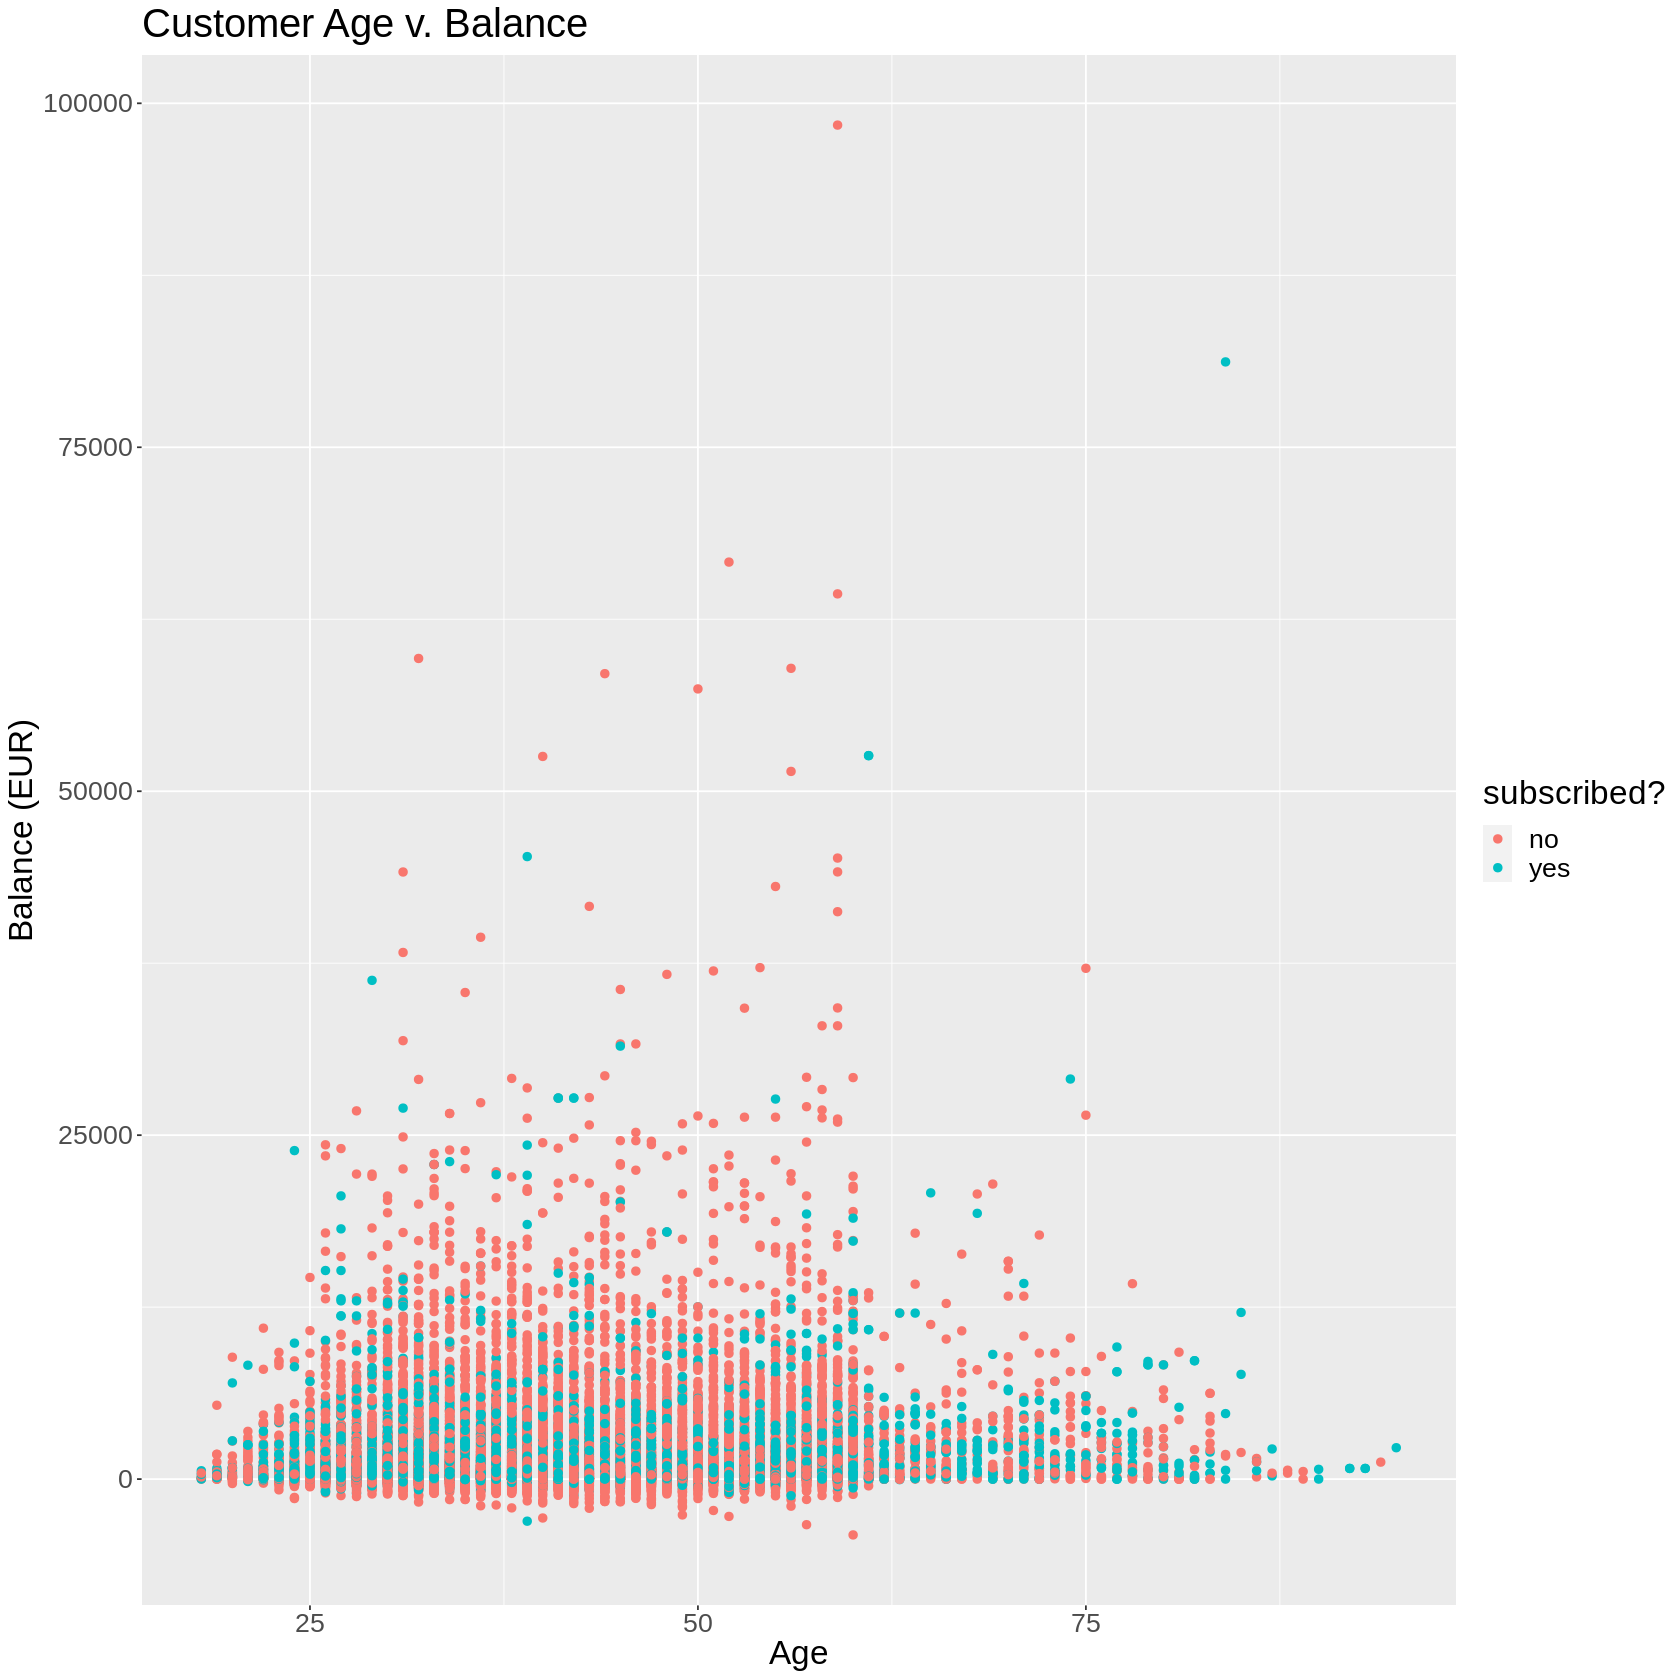

In [45]:
options(repr.plot.width=14, repr.plot.height=14)
balance_vs_age <- bank_training %>%
    ggplot(aes(x = age, y = balance, colour = y)) +
    labs(x = "Age", y = "Balance (EUR)", colour = 'subscribed?') +
    geom_point(size = 2) +
    theme(text = element_text(size = 20)) +
    ggtitle("Customer Age v. Balance")
balance_vs_age

The most significant takeaway is that there is a tighter bound on the balance range of subscribers than of non-subscribers, which skews towards lower balance.

The following plots inspect the distribution of people who did and did not subscribe with respect to their job type.

options(repr.plot.width=14, repr.plot.height=8)
plot_per_job <- bank_training %>%
    ggplot(aes(x = job, fill = y)) + 
    geom_bar(position = 'fill') +
    xlab('Job Type') +
    ylab('Is Subscriber') +
    labs(fill = "Is Subscriber") +
    scale_fill_brewer(palette = "Paired") +
    theme(text = element_text(size = 22), axis.text.x = element_text(angle = 40, hjust = 1)) +
    ggtitle("Customer Job Type Subscriber Ratios")

plot_per_job

options(repr.plot.width=10, repr.plot.height=12)
plot_job2 <- bank_training %>%
    ggplot(aes(x = y, fill = job)) + 
    geom_bar(position = 'fill') +
    xlab('Is Subscriber') +
    ylab('Job Type') +
    labs(fill = "Job Type") +
    scale_fill_brewer(palette = "Paired") +
    theme(text = element_text(size = 22)) + 
    ggtitle("Customer Job Type Subscriber Ratios (Stacked)")

plot_job2

The plots concerning jobs imply two insights:
* Students and retirees are the most likely to subscribe to the deposit
* Management, technician and admin jobs constitute the largest portions of the subscribers

### Methods

When refering to `bank_trimmed` we can see that we filtered out the columns we thought would not play any relationship to whether or not a client subscribed a term deposit. The columns we did not include are default, contact, duration. We will consider all other columns as they may have a relationship with clients subscribing. We will compare all the other columns to clients subscribing. We will figure out the relationship (if any) through various graphs. These graphs depend on whether or not the predictor is a quantitative variable or a qualitative variable. We will than use the $k$ nearest algorithm with both classification and regression to predict the cases in our testing data. To come up with the best $k$ value, we will foldour training data.

### Expected outcomes and significance

Based on our preliminary analysis, we expect to find a few relationships. First, we expect that balance and job type both have a discernible relationship on whether or not clients subscribe. We also believe that the peak age for subscribing will be around 35-40 years of age and that married clients tend to subscribe more often than singles. These impacts could change the marketing and advertising of term deposit to show that it does not require a certain amount of money or that you can start at any age. These findings could lead to further questions such as "do married couples tend to be more financially responsible than singles?" or "at what age do people tend to care about their money the most?" Many further questions can be analyzed after this project.